## 1. Input Embeddings:

The `InputEmbeddings` class is responsible for converting tokenized input sequences into dense vector representations (embeddings) suitable for the Transformer model. This embedding process includes scaling the embeddings by the square root of the model’s dimension (`d_model`), a standard technique introduced in the original Transformer paper. This class uses PyTorch’s `nn.Embedding` to transform indices into corresponding vectors. The `forward` method processes the input batch and returns the embeddings.


In [ ]:
# Import necessary libraries
import torch  # Core library for tensor operations
import torch.nn as nn  # PyTorch's neural network module
import math  # Library to perform mathematical operations, used for sqrt
import numpy as np # Numpy library
class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model  # Dimension of the embeddings (model size)
        self.vocab_size = vocab_size  # Vocabulary size, i.e., the number of unique tokens
        # Embedding layer that converts token indices to vectors of size d_model
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        # x is a batch of input token indices of shape (batch_size, seq_len)
        # We apply the embedding layer to convert token indices to vectors
        # Shape becomes (batch_size, seq_len, d_model)

        # The embeddings are scaled by sqrt(d_model), as suggested in the Transformer paper
        # You will need to use the math library to apply the scaling factor.

        # TODO: Complete the return statement by multiplying the embeddings by the square root of d_model
        return self.embedding(x) *___   # <--- fill with the necessary code


### Grading Input Embeddings
Do not move to the next section without succeeding this section

In [ ]:
# Validation function to check if sqrt(d_model) scaling is correctly implemented
def validate_input_embeddings():
    # Define test parameters
    vocab_size = 1000  # Assume a vocabulary size of 1000 words
    d_model = 512  # Assume the model size (embedding dimension) is 512

    # Create the InputEmbeddings instance
    input_embed = InputEmbeddings(d_model, vocab_size)

    # Generate random token indices for a batch of sequences
    batch_size = 4
    seq_len = 10  # Example sequence length
    sample_input = torch.randint(0, vocab_size, (batch_size, seq_len))

    # Get embeddings for the input batch
    embeddings = input_embed(sample_input)

    # Check if the embeddings have been scaled by sqrt(d_model)
    expected_scale = math.sqrt(d_model)  # Correct scaling factor

    # Get the norm of the first token embedding before and after scaling
    original_embedding = input_embed.embedding(sample_input)[0, 0]  # First token embedding without scaling
    scaled_embedding = embeddings[0, 0]  # First token embedding with scaling

    # Calculate the norm ratio to check if the scaling was applied
    scaling_ratio = scaled_embedding.norm().item() / original_embedding.norm().item()

    # Check if the scaling ratio is close to the expected sqrt(d_model)
    if math.isclose(scaling_ratio, expected_scale, rel_tol=1e-5):
        print(f"Test passed!✅ The embeddings were correctly scaled by sqrt(d_model) = {expected_scale:.2f}")
    else:
        print(f"Test failed.❌ Expected scaling factor: {expected_scale:.2f}, but got {scaling_ratio:.2f}. Please check your code.")

# Run the validation function
validate_input_embeddings()


## 2. Positional Encoding

The `PositionalEncoding` class generates positional encodings that help the Transformer model recognize the order of tokens in a sequence, as it lacks any inherent notion of token position. This encoding is added to the input embeddings, with sine and cosine functions applied to the positions in alternating dimensions of the encoding matrix. You will complete the code where necessary and ensure the positional encodings are applied correctly.

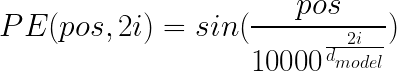

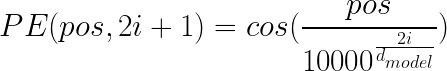


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import math

# Class to create positional encodings for sequence data
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model  # Model dimensionality
        self.seq_len = seq_len  # Length of the input sequences
        self.dropout = nn.Dropout(dropout)  # Dropout layer to prevent overfitting

        # Create a matrix to hold positional encodings of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)

        # Create a vector of shape (seq_len, 1) to represent positions
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)  # Shape: (seq_len, 1)

        # Create a vector of shape (d_model / 2) for frequency terms
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # TODO: Apply sine to even indices in the positional encoding matrix
        pe[:, 0::2] = torch.sin(position * ____)  # <--- complete this part

        # TODO: Apply cosine to odd indices in the positional encoding matrix
        pe[:, 1::2] = ___  # <--- complete this part

        # Add a batch dimension to the positional encoding matrix
        pe = pe.unsqueeze(0)  # Shape becomes (1, seq_len, d_model)

        # Register the positional encoding as a buffer so it's not updated during backpropagation
        self.register_buffer('pe', pe)

    def forward(self, x):

        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)

        # Apply dropout to prevent overfitting
        return self.dropout(x)


### Grading Positional Encoding
Do not move to the next section without succeeding this section

In [ ]:
# Validation for PositionalEncoding class

def validate_positional_encoding():
    # Define test parameters
    d_model = 512  # Model size (embedding dimension)
    seq_len = 50   # Sequence length
    dropout = 0.1  # Dropout rate

    # Create the PositionalEncoding instance
    positional_encoding = PositionalEncoding(d_model, seq_len, dropout)

    # Create a batch of zero vectors representing input embeddings
    batch_size = 4
    input_embeddings = torch.zeros(batch_size, seq_len, d_model)

    # Apply positional encoding to the input embeddings
    encoded_embeddings = positional_encoding(input_embeddings)

    # Test 1: Check if positional encodings have been added (not all zeros)
    test1_passed = not torch.allclose(encoded_embeddings, torch.zeros_like(encoded_embeddings))

    # Test 2: Check shape of the output
    test2_passed = encoded_embeddings.shape == (batch_size, seq_len, d_model)

    # Test 3: Validate that the positional encoding for position 0 is not all zeros
    position_0_encoding = positional_encoding.pe[0, 0, :].detach().numpy()
    test3_passed = not np.all(position_0_encoding == 0)

    # Test 4: Check that applying positional encodings to different input embeddings yields different results
    input_embeddings_2 = torch.ones(batch_size, seq_len, d_model)  # A different input
    encoded_embeddings_2 = positional_encoding(input_embeddings_2)
    test4_passed = not torch.allclose(encoded_embeddings, encoded_embeddings_2)

    # Test 5: Check if dropout keeps some elements zero (this might fail sometimes depending on random drop)
    # To make this deterministic, we can set a seed (optional)
    torch.manual_seed(0)
    encoded_embeddings_dropped = positional_encoding(input_embeddings)
    # Apply the same dropout manually to see if any values are zero
    dropped_check = torch.sum(encoded_embeddings_dropped == 0).item() > 0
    test5_passed = dropped_check

    # Summarize results
    tests = [test1_passed, test2_passed, test3_passed, test4_passed, test5_passed]
    print(f"Results of PositionalEncoding Validation: {sum(tests)}/{len(tests)} tests passed.")

    # Visualize the positional encoding for a sample sequence
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Extract the positional encodings (before dropout) for visualization
    pe = positional_encoding.pe.squeeze(0).detach().numpy()  # Shape: (seq_len, d_model)

    plt.figure(figsize=(10, 6))
    sns.heatmap(pe, cmap="coolwarm", cbar=True)
    plt.title('Heatmap of Positional Encodings (Sequence Length vs Embedding Dimensions)')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Position in Sequence')
    plt.show()

# Call the validation function
validate_positional_encoding()




## 3. Layer Normalization

`LayerNormalization` is a custom implementation of layer normalization, which normalizes the input along the last dimension (features) for each sequence in the batch. It helps to stabilize and speed up training by ensuring that each feature in the input has zero mean and unit variance. You will complete the code where necessary to implement the normalization and broadcasting.



In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn

# Custom implementation of Layer Normalization
class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps: float = 10**-6) -> None:
        super().__init__()
        self.eps = eps  # Small value to prevent division by zero
        # Learnable parameters for scaling (alpha) and bias
        self.alpha = nn.Parameter(torch.ones(features))  # Alpha is initialized to 1
        self.bias = nn.Parameter(torch.zeros(features))  # Bias is initialized to 0

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)

        # TODO: Calculate the mean of x along the last dimension, keeping the dimension for broadcasting
        mean = ___  # <--- Fill up this section (x.mean(dim=-1, keepdim=True))

        # TODO: Calculate the standard deviation of x along the last dimension, keeping the dimension for broadcasting
        std = ___  # <--- Fill up this section (x.std(dim=-1, keepdim=True))

        # TODO: Normalize x using the calculated mean and standard deviation, and scale with alpha, bias
        return ___  # <--- Fill up this section (self.alpha * (x - mean) / (std + self.eps) + self.bias)


### Grading Layer Normalization
Do not move to the next section without succeeding this section

In [ ]:
# Validation for LayerNormalization class

def validate_layer_normalization():
    # Define test parameters
    features = 512  # Hidden size
    batch_size = 4  # Batch size
    seq_len = 10    # Sequence length
    eps = 1e-6      # Small value for numerical stability

    # Create LayerNormalization instance
    layer_norm = LayerNormalization(features, eps)

    # Create random input tensor with shape (batch_size, seq_len, features)
    input_tensor = torch.randn(batch_size, seq_len, features)

    # Apply layer normalization
    normalized_output = layer_norm(input_tensor)

    # Test 1: Check that the output has the same shape as the input
    test1_passed = normalized_output.shape == input_tensor.shape

    # Test 2: Verify that the mean of the output is approximately zero for each feature across sequences
    mean_per_feature = normalized_output.mean(dim=-1)  # Mean along the feature dimension
    test2_passed = torch.allclose(mean_per_feature, torch.zeros_like(mean_per_feature), atol=1e-5)

    # Test 3: Verify that the standard deviation of the output is approximately one for each feature across sequences
    std_per_feature = normalized_output.std(dim=-1)  # Std along the feature dimension
    test3_passed = torch.allclose(std_per_feature, torch.ones_like(std_per_feature), atol=1e-5)

    # Test 4: Apply layer normalization to different inputs and verify that they give different results
    input_tensor_2 = torch.randn(batch_size, seq_len, features)
    normalized_output_2 = layer_norm(input_tensor_2)
    test4_passed = not torch.allclose(normalized_output, normalized_output_2)

    # Summarize results
    tests = [test1_passed, test2_passed, test3_passed, test4_passed]
    print(f"Results of LayerNormalization Validation: {sum(tests)}/{len(tests)} tests passed.")



# Call the validation function
validate_layer_normalization()


## 4. Feed Forward Block
The FeedForwardBlock is a crucial component in the Transformer architecture. It applies a two-layer feed-forward network to each position in the sequence, separately and identically. The first layer maps from the model dimension (`d_model`) to a higher-dimensional space (`d_ff`), followed by a ReLU activation function, dropout for regularization, and a second linear layer that projects back to the model dimension. This block allows the model to capture more complex transformations after the multi-head attention mechanism.

Fill up this section to complete the code and implement the feed-forward block.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        # TODO what module ?
        self.linear_2 = nn.____(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        # TODO what activation?
        return self.linear_2(self.dropout(torch.____(self.linear_1(x))))



### Self-grading Feed Forward Network
Check with answers to see if it matches


In [ ]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

### 5. Residual Connection
The `ResidualConnection` class implements a key part of the Transformer architecture, which adds a residual (or skip) connection around a sublayer, such as a feed-forward network or multi-head attention. Additionally, layer normalization and dropout are applied to stabilize training and improve generalization. Residual connections are essential for deep models to mitigate the vanishing gradient problem.

Fill up this section by adding the key components: layer normalization, dropout, and the residual addition.



In [ ]:
class ResidualConnection(nn.Module):

    def __init__(self, features: int, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)  # Initialize dropout layer with the specified dropout rate
        self.norm = LayerNormalization(features)  # Initialize layer normalization with the given number of features

    # Apply layer normalization to the input x
    # Pass the normalized output through the sublayer (e.g., an attention layer or feed-forward network)
    # Apply dropout to the result of the sublayer
    # Add the original input x to the result to create a residual connection
    # TODO complete the forward method
    def forward(self, x, sublayer):
        return ____  # Implement the forward pass as


### Self-grading Residual Connection
Match your output with the following *section*

In [ ]:
# DO NOT RUN THIS. JUST CHECK
class ResidualConnection(nn.Module):

    def __init__(self, features: int, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)  # Initialize dropout layer with the specified dropout rate
        self.norm = LayerNormalization(features)  # Initialize layer normalization with the given number of features

    # Apply layer normalization to the input x
    # Pass the normalized output through the sublayer (e.g., an attention layer or feed-forward network)
    # Apply dropout to the result of the sublayer
    # Add the original input x to the result to create a residual connection
    # TODO complete the forward method
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

### 6. Multi-Head Attention Block
In this section, we will implement a Multi-Head Attention mechanism, which is a crucial component of the Transformer architecture. Multi-Head Attention allows the model to focus on different parts of the input sequence simultaneously. The mechanism involves projecting the input into multiple heads, calculating attention scores, and then combining the results.

The following code defines the `MultiHeadAttentionBlock` class, which includes the initialization of necessary weights and the forward pass computation.

In [ ]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq

        # TODO define self.w_k
        self.w_k = ____

        # TODO self.w_v
        self.w_v = ____

        # TODO self.w_o
        self.w_o = ____

        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)

        # TODO completion the attention score formula
        attention_scores = (query @ key.transpose(-2, -1)) / ____
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        # TODO complete the value transformation
        value = ____

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        return self.w_o(x)

### Self-grading Multi-Head Attention
Check the answers and match with yours


In [ ]:
# DO NOT RUN THIS. JUST CHECK THE CODE
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        return self.w_o(x)

### 7. Encoder
The Encoder class in a Transformer architecture consists of multiple stacked Encoder Blocks. Each block applies self-attention and a feed-forward network, with residual connections enhancing the model's capacity to learn complex representations. The final output is normalized to improve convergence during training.

In this section, we will implement the `Encoder` class, which utilizes a list of `EncoderBlock` instances.


In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        # TODO What are the three inputs to the residual connection?
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(____, ____, ____, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


### Self-grading Encoder
Check the answers to match with yours

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

### 8. Decoder
The Decoder class in a Transformer architecture is responsible for generating outputs based on encoded inputs. It consists of multiple stacked Decoder Blocks, each incorporating self-attention, cross-attention to encoder outputs, and feed-forward networks, complemented by residual connections to enhance learning.

In this section, we will implement the `Decoder` class along with its `DecoderBlock`, which processes the input sequence and attends to the encoder's output.


In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        # TODO complete the residual connections
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(____)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        # TODO finish initializing the Decoer


    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

### Self-grading Decoder
Check the answers to match with yours

In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

### 9. Projection Layer
The Projection Layer is an essential component of the Transformer architecture, primarily used to map the output of the decoder (or any other component with a d_model-sized output) to the vocabulary size. This layer facilitates the generation of probabilities for each token in the vocabulary for the next predicted token in a sequence.

In this section, we will implement the `ProjectionLayer`, which will transform the model's output to match the vocabulary size.


In [ ]:
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        #TODO what module should be here?
        self.proj = nn.____(d_model, vocab_size)

    def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return self.proj(x)

### Self-grading Projection Layer
Check the answers to match with yours

In [ ]:
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return self.proj(x)

### 10. Transformer Class
The `Transformer` class encapsulates the entire architecture of the Transformer model. It integrates the encoder and decoder components along with their respective input embeddings, positional encodings, and the projection layer. This class handles the encoding of the source sequences and the decoding of target sequences while managing the flow of information throughout the architecture.

In this section, we will implement the `Transformer` class and its key functionalities, including encoding and decoding.


In [ ]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        # TODO similarly, fill up for the rest of the attributes

    def encode(self, src, src_mask):
        # (batch, seq_len, d_model)
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        #TODO complete the decode method
        # what is tgt going to be here?
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)

### Self-grading Transformer class
Check with the answers to match with yours

In [ ]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        # (batch, seq_len, d_model)
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)

### 11. Putting It All Together
In this segment, we will finally finish building our transformer model

In [ ]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    # TODO Fill this up
    tgt_embed = ____

    # Create the positional encoding layers
    # TODO fill this upo
    src_pos = ____
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        # TODO  complete the decoder block
        decoder_self_attention_block = ____
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer

### Final Self-Grading
Check with the answers to match with yours

In [ ]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer